In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt

c:\Users\tothm\.conda\envs\ai_learn\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] A megadott eljárás nem található'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# Getting the datasets

import random


class AddRandomNoise(object):
    def __init__(self, noise_range=(0, 0.3)):
        self.noise_range = noise_range

    def __call__(self, img):
        noise_level = random.uniform(self.noise_range[0], self.noise_range[1])
        noise = torch.randn_like(img) * noise_level
        return img + noise

transform = transforms.Compose([
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    AddRandomNoise(noise_range=(0, 0.2)),
    #transforms.Normalize((-1,), (1,)),
])

train_ds = MNIST(root='data', train=True, download=True, transform=transform)
valid_ds = MNIST(root='data', train=False, download=True, transform=transform)

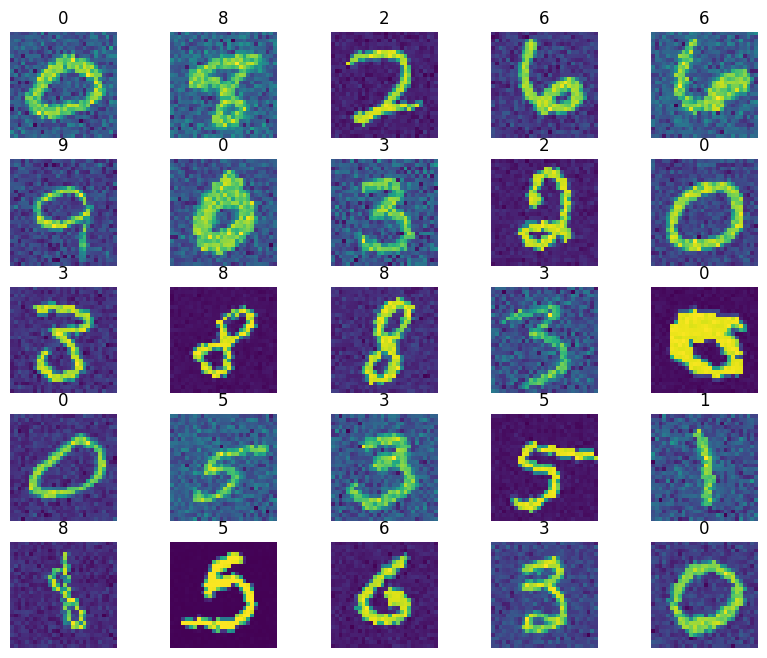

In [4]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_ds), size=(1,)).item()
    img, label = train_ds[sample_idx] # type: ignore
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="viridis")
plt.show()

In [5]:
# Create data loader 
# GPU acceleration -> num_workers, pin_memory (faster ram to gpu transfer)
bs = 64
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True)

In [6]:
from torch import nn

# build model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

# init model
model = CNN()
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [7]:
from torch import optim

lr = 0.05

# define a loss func & optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr) # method of gradient descent (or Adam) learning rate

# accuracy func for logging
def accuracy_func(pred, yb):
    pred_class = torch.argmax(pred, dim=1)
    return (pred_class == yb).float().mean()

In [8]:
# Create the trainer
def train(dataloader, model, loss_func, optimizer):
    for batch_idx, (xb, yb) in enumerate(dataloader): # take input and label from data loader
        
        # loss
        pred = model(xb)[0]
        loss = loss_func(pred, yb)

        # backprop
        loss.backward() # autograd
        optimizer.step() # updates the parameters using the optimizer we provided
        optimizer.zero_grad() # wipe the gradients for the next it

        # logging
        if batch_idx % 100 == 0:
            train_loss, train_accuracy = loss.item(), accuracy_func(pred, yb).item() * 100
            print(f'Loss: {train_loss:6f} Accuracy: {train_accuracy:0.1f}%')

In [9]:
# Define test
def test(dataloader, model, loss_func):
    model.eval() # flag to make sure things like dropout works as expected in testing
    with torch.no_grad(): # because not updating
        for xb, yb in dataloader:
            pred = model(xb)[0]
            loss = loss_func(pred, yb)
            accuracy = accuracy_func(pred, yb)

            test_loss, test_accuracy = loss.item(), accuracy.item() * 100
    print(f'Test:\n Loss: {test_loss:6f} Accuracy: {test_accuracy:0.1f}%')

In [10]:
# RUN

epochs = 5

for t in range(epochs):
    print(f'\nEpoch {t}\n-----------------')
    train(train_dl, model, loss_func, optimizer)
    test(valid_dl, model, loss_func)
print('\nFinished!')


Epoch 0
-----------------


Loss: 2.295302 Accuracy: 9.4%
Loss: 0.914541 Accuracy: 76.6%
Loss: 0.471095 Accuracy: 84.4%
Loss: 0.368092 Accuracy: 90.6%
Loss: 0.494878 Accuracy: 84.4%
Loss: 0.200678 Accuracy: 93.8%
Loss: 0.348662 Accuracy: 90.6%
Loss: 0.232308 Accuracy: 95.3%
Loss: 0.369444 Accuracy: 89.1%
Loss: 0.564363 Accuracy: 89.1%
Test:
 Loss: 0.208118 Accuracy: 87.5%

Epoch 1
-----------------
Loss: 0.235278 Accuracy: 92.2%
Loss: 0.541402 Accuracy: 85.9%
Loss: 0.318349 Accuracy: 90.6%
Loss: 0.448523 Accuracy: 84.4%
Loss: 0.144690 Accuracy: 95.3%
Loss: 0.216150 Accuracy: 90.6%
Loss: 0.236759 Accuracy: 92.2%
Loss: 0.219293 Accuracy: 85.9%
Loss: 0.307226 Accuracy: 89.1%
Loss: 0.607467 Accuracy: 90.6%
Test:
 Loss: 0.376220 Accuracy: 87.5%

Epoch 2
-----------------
Loss: 0.138852 Accuracy: 95.3%
Loss: 0.267644 Accuracy: 92.2%
Loss: 0.308609 Accuracy: 89.1%
Loss: 0.100369 Accuracy: 96.9%
Loss: 0.441910 Accuracy: 89.1%
Loss: 0.087414 Accuracy: 98.4%
Loss: 0.244438 Accuracy: 92.2%
Loss: 0.312877 Accuracy: 84.4%
Los